In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2' ## supress tensorflow-metal warnings

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
DIRECTROY = 'dataset'
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50
TRAIN_SIZE = 0.8
TEST_SIZE = 0.1
VAL_SIZE = 0.1

In [65]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    DIRECTROY,
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True,
)

class_names = dataset.class_names
class_names = ['Early Blight', 'Late Blight', 'Healthy']

Found 2152 files belonging to 3 classes.


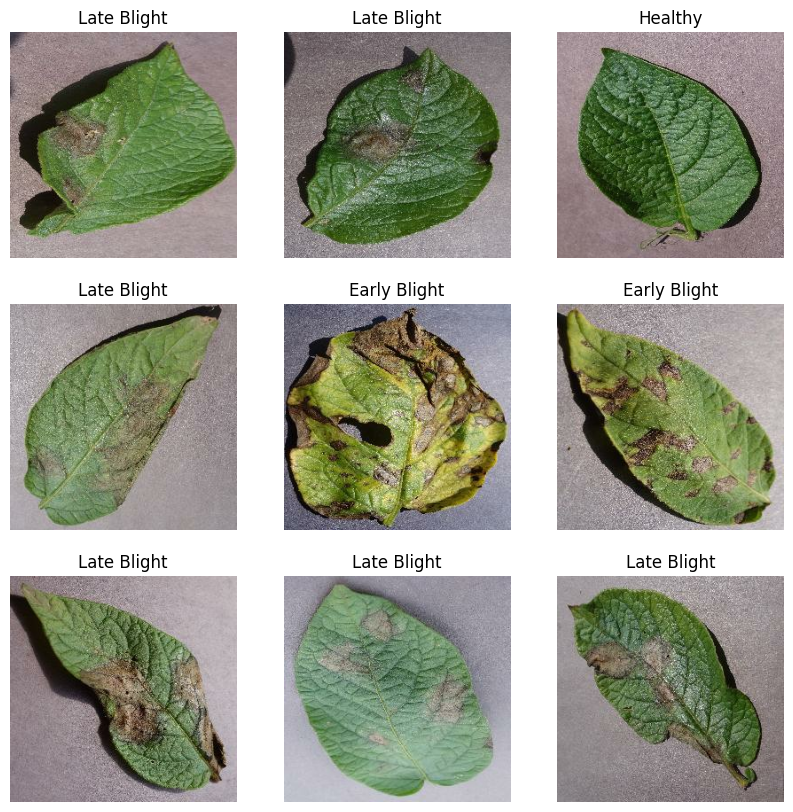

In [66]:
for images, labels in dataset.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [5]:
def get_dataset_partitions(dataset, train_split=TRAIN_SIZE, val_split=VAL_SIZE, test_split=TEST_SIZE, shuffle=True, shuffle_size=10000):
    if shuffle:
        dataset = dataset.shuffle(shuffle_size, reshuffle_each_iteration=False)

    train_size = int(train_split * len(dataset))
    val_size = int(val_split * len(dataset))

    train_dataset = dataset.take(train_size)
    test_dataset = dataset.skip(train_size)
    val_dataset = test_dataset.take(val_size)
    test_dataset = test_dataset.skip(val_size)

    return train_dataset, val_dataset, test_dataset

train_dataset, val_dataset, test_dataset = get_dataset_partitions(dataset)

# train_dataset = dataset.take(int(len(dataset) * TRAIN_SIZE))
# test_dataset = dataset.skip(int(len(dataset) * TRAIN_SIZE))
# val_dataset = test_dataset.take(int(len(dataset) * VAL_SIZE))
# test_dataset = test_dataset.skip(int(len(val_dataset)))

In [6]:
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [7]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.experimental.preprocessing.Rescaling(1. / 255)
])

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [140]:
model = tf.keras.Sequential([
    resize_and_rescale,
    data_augmentation,
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(192, activation='relu'),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

In [141]:
model.build(input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_54 (Conv2D)          (32, 256, 256, 16)        448       
                                                                 
 max_pooling2d_54 (MaxPooli  (32, 128, 128, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_55 (Conv2D)          (32, 128, 128, 32)        4640      
                                                                 
 max_pooling2d_55 (MaxPooli  (32, 64, 64, 32)          0         
 ng2D)                                               

In [142]:
model.compile(
    optimizer='SGD', 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
    )

In [143]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)


Epoch 1/50


/Users/anuragchakraborty/Code/ML/PotatoDoc/venv/lib/python3.11/site-packages/keras/src/backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


54/54 [==============================] - 12s 205ms/step - loss: 0.9212 - accuracy: 0.4759 - val_loss: 0.8561 - val_accuracy: 0.6823
Epoch 2/50
54/54 [==============================] - 13s 247ms/step - loss: 0.8824 - accuracy: 0.5317 - val_loss: 0.8381 - val_accuracy: 0.7969
Epoch 3/50
54/54 [==============================] - 14s 260ms/step - loss: 0.8613 - accuracy: 0.5775 - val_loss: 0.8118 - val_accuracy: 0.7448
Epoch 4/50
54/54 [==============================] - 14s 254ms/step - loss: 0.8292 - accuracy: 0.6309 - val_loss: 0.7399 - val_accuracy: 0.8281
Epoch 5/50
54/54 [==============================] - 14s 263ms/step - loss: 0.7445 - accuracy: 0.7031 - val_loss: 0.6432 - val_accuracy: 0.7760
Epoch 6/50
54/54 [==============================] - 19s 354ms/step - loss: 0.6523 - accuracy: 0.7512 - val_loss: 0.5190 - val_accuracy: 0.8281
Epoch 7/50
54/54 [==============================] - 16s 294ms/step - loss: 0.5775 - accuracy: 0.7711 - val_loss: 0.4705 - val_accuracy: 0.8385
Epoch 8/50

In [193]:
scores = model.evaluate(test_dataset, verbose=1)

8/8 [==============================] - 0s 33ms/step - loss: 0.0412 - accuracy: 0.9766


In [199]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy, AUC
from sklearn.metrics import classification_report

y_pred = model.predict(test_dataset, verbose=1, batch_size=BATCH_SIZE)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

print(classification_report(y_true, y_pred, target_names=class_names))

Precision = Precision()
Precision.update_state(y_true, y_pred)
print("Precision: ", Precision.result().numpy())

Recall = Recall()
Recall.update_state(y_true, y_pred)
print("Recall: ", Recall.result().numpy())

Accuracy = CategoricalAccuracy()
Accuracy.update_state(y_true, y_pred)
print("Accuracy: ", Accuracy.result().numpy())

AUC = AUC()
AUC.update_state(y_true, y_pred)
print("AUC: ", AUC.result().numpy())


8/8 [==============================] - 0s 29ms/step
              precision    recall  f1-score   support

Early Blight       0.63      0.62      0.62       115
 Late Blight       0.67      0.67      0.67       126
     Healthy       0.29      0.33      0.31        15

    accuracy                           0.62       256
   macro avg       0.53      0.54      0.53       256
weighted avg       0.63      0.62      0.63       256

Precision:  0.6923077
Recall:  0.70212764
Accuracy:  0.0
AUC:  0.6597595


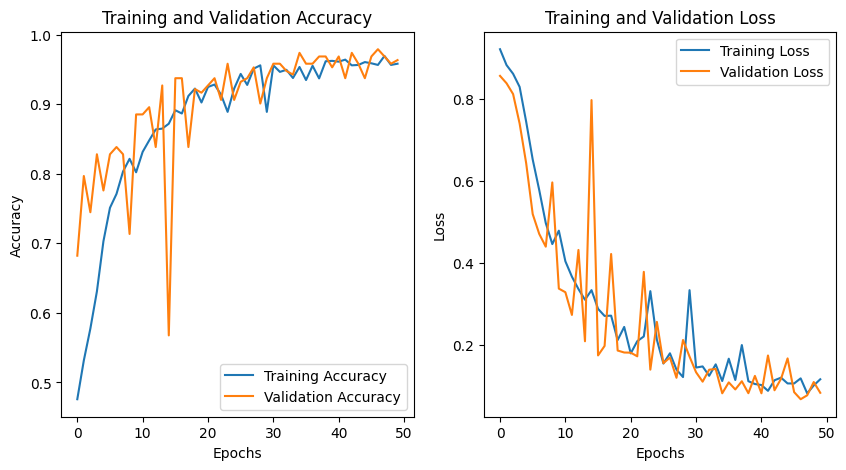

Test loss: 0.04119311273097992
Test accuracy: 0.9765625


In [146]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

In [147]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array, verbose=0)

    predicted_class = class_names[np.argmax(predictions[0])]

    confidence = round(100 * (np.max(predictions[0])), 2)


    return predicted_class, confidence

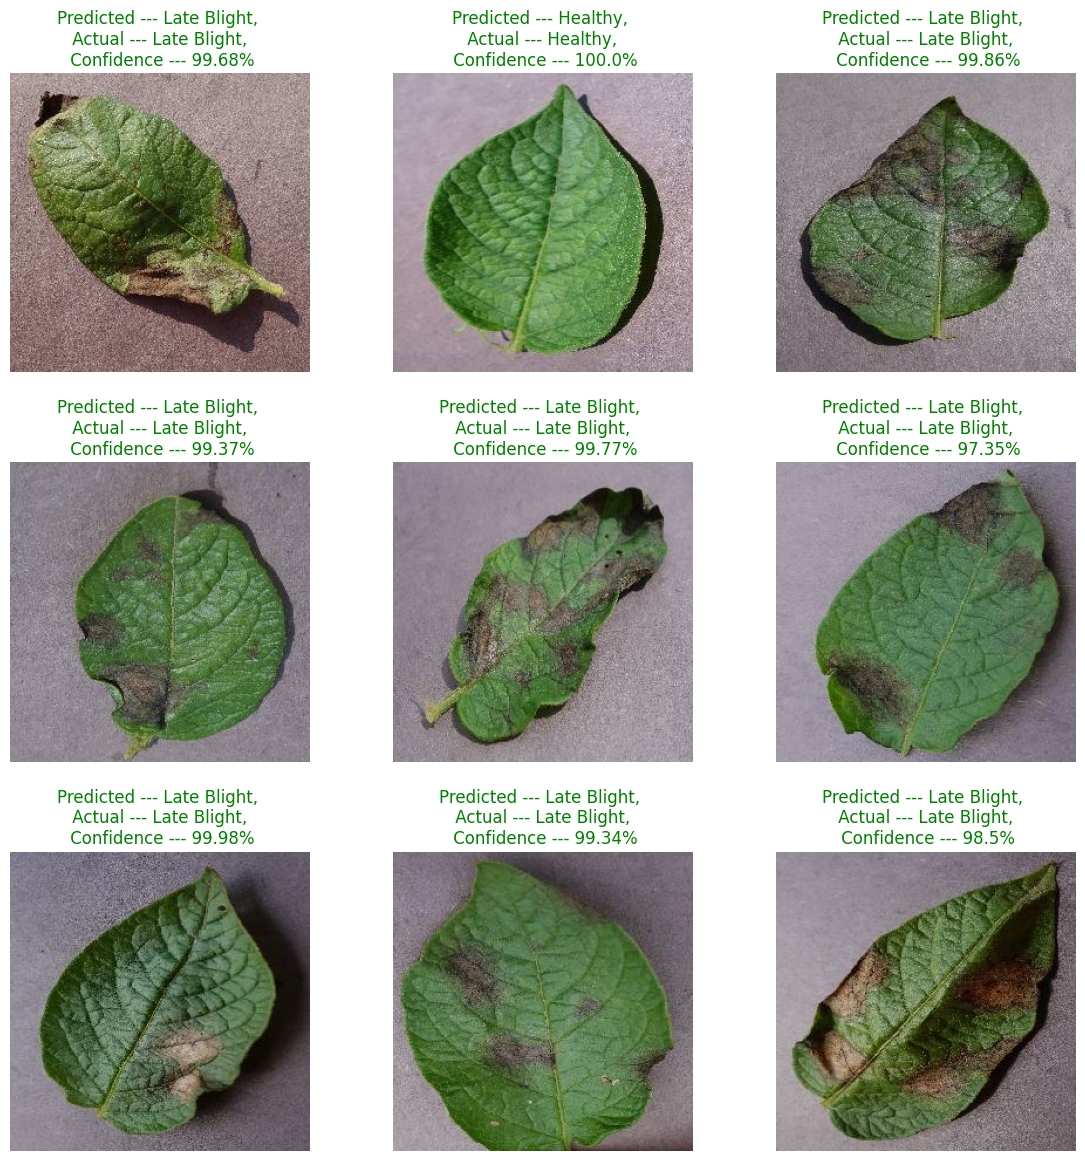

In [148]:
for images, labels in test_dataset.take(1):
    plt.figure(figsize=(14, 14))
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
     
        predicted_class, confidence = predict(model, images[i])

        actual_class = class_names[labels[i]]

        if predicted_class == actual_class:
            color = 'green'
        else:
            color = 'red'

        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(f'Predicted --- {predicted_class}, \n Actual --- {actual_class}, \n Confidence --- {confidence}%', color=color)
        plt.subplots_adjust(hspace=0.3)
        plt.axis('off')


In [149]:
model_version = 1.1
model.save(f'./saved_models/version_{model_version}', save_format='tf')

INFO:tensorflow:Assets written to: ./saved_models/version_1.1/assets


INFO:tensorflow:Assets written to: ./saved_models/version_1.1/assets
